# Random-Forest Structure-Property Model

In [1]:
import sys, os
import pandas as pd
import numpy as np

from rdkit import Chem

sys.path.append('../../Woodward_Fieser_Rules-main/src/')
import chromopredict as cp

In [2]:
d_kang = {
    1: {'smiles': 'C=CC(=O)C', 'nm_exp': 214},
    2: {'smiles': 'C=CC(=O)CCCCCCCCCC', 'nm_exp': 212},
    3: {'smiles': 'C=CC(=O)CC1CCCCC1', 'nm_exp': 213},
    4: {'smiles': 'C=CC(=O)CC1=CC=CC=C1', 'nm_exp': 210},
    5: {'smiles': 'C=CC(=O)C1CCCCC1', 'nm_exp': 212},
    6: {'smiles': 'C=CC(=O)C1CCC2(CC1)OCCO2', 'nm_exp': 214},
    7: {'smiles': 'C=CC(=O)C1CCCCCC1', 'nm_exp': 212.5},
    8: {'smiles': 'C=C1CCCC1=O', 'nm_exp': 231},
    9: {'smiles': 'C=C1CCCCC1=O', 'nm_exp': 230},
    10: {'smiles': 'C=C1CCCCCC1=O', 'nm_exp': 230},
    11: {'smiles': 'C=C1C[C@H]2[C@@H]3CC[C@@H]4C[C@@H](CC[C@]4(C)[C@H]3C(=O)C[C@]2(C)C1=O)OC(=O)C', 'nm_exp': 228},
    12: {'smiles': 'C=C1C[C@H]2[C@@H]3CC[C@@H]4C[C@@H](CC[C@]4(C)[C@H]3[C@H](C[C@]2(C)C1=O)O)O', 'nm_exp': 227},
    13: {'smiles': 'C1CCC(=C2CCCC2=O)C1', 'nm_exp': 259},
    14: {'smiles': 'C1CCC(=C2CCCCC2=O)CC1', 'nm_exp': 257},
    15: {'smiles': 'CCCCCCCC[C@H]1CC(=O)C2=C3CC[C@H]4C[C@H](CC[C@]4(C)[C@H]3CC[C@]12C)OC(=O)C', 'nm_exp': 257},
    16: {'smiles': 'CCCCCCCC[C@H]1C[C@H](C2=C3[C@H](CC[C@]12C)[C@@]4(C)CC[C@@H](C[C@@H]4CC3=O)OC(=O)C)OC(=O)C', 'nm_exp': 256},
    17: {'smiles': 'CCCCCCCC[C@H]1C[C@@H](C2=C3[C@H](CC[C@]12C)[C@@]4(C)CC[C@@H](C[C@@H]4CC3=O)OC(=O)C)OC(=O)C', 'nm_exp': 257},
    18: {'smiles': 'CC(=O)C1=C(C)CCCC1', 'nm_exp': 247},
    19: {'smiles': 'CC(C)=C1CCC(C)CC1=O', 'nm_exp': 252},
    20: {'smiles': 'CC1=CC(=O)CC(C)(C)C1', 'nm_exp': 235},
    21: {'smiles': 'CC1=C2CCCCC2CCC1=O', 'nm_exp': 239},
    22: {'smiles': 'CC=CC=CC=O', 'nm_exp': 261},
    23: {'smiles': 'CC(=O)C=CC1=C(C)CCCC1(C)C', 'nm_exp': 283},
    24: {'smiles': 'CC(=C1CCCCC1)C(=O)C', 'nm_exp': 242},
    25: {'smiles': 'C[C@@H]1CCC(=C(C)C)C(=O)C1', 'nm_exp': 252},
    26: {'smiles': 'C[C@H](CCCC(C)C)[C@H]1CC[C@@H]2[C@@]1(CC[C@H]3[C@H]2CCC4=C(C(=O)CC[C@]34C)Br)C', 'nm_exp': 256},
    27: {'smiles': 'CC12CCC(=O)C(Br)=C1CC[C@@H]1[C@@H]2CC[C@]2(C)C(=O)CC[C@@H]12', 'nm_exp': 254},
    28: {'smiles': 'CC=CC=CC=CC(=O)O', 'nm_exp': 297},
    #28: {'smiles': 'CC(=O)OC1=CCC3(C)C(=C1)C=CC2CCCCC23', 'nm_exp': 306},
    #30: {'smiles': 'C=C1CCCCC1=C', 'nm_exp': 220},
}

for idx, d_ in d_kang.items():
    smi = d_['smiles']
    if smi != '':
        d_['nm_wf'], _, _ = cp.predict(smi, solvent=None, verbose=False, draw=False, chromlib='woodward')
        d_['nm_wfe'], _, _ = cp.predict(smi, solvent=None, verbose=False, draw=False, chromlib='woodward_extended')
        d_['nm_wfr'], _, _ = cp.predict(smi, solvent=None, verbose=False, draw=False, chromlib='woodward_refine')
        #print(descr)

df_inference = pd.DataFrame.from_dict(d_kang, orient='index')
df_inference.head(n=5)

,smiles,nm_exp,nm_wf,nm_wfe,nm_wfr
1,C=CC(=O)C,214.0,215,213,212
2,C=CC(=O)CCCCCCCCCC,212.0,215,213,212
3,C=CC(=O)CC1CCCCC1,213.0,215,213,212
4,C=CC(=O)CC1=CC=CC=C1,210.0,305,245,242
5,C=CC(=O)C1CCCCC1,212.0,215,213,212


In [3]:
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from rdkit.Chem import MACCSkeys
from rdkit import DataStructs

def featurize(smiles, radius, fp_size):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return np.zeros(fp_size)
    
    fmgen = rdFingerprintGenerator.GetMorganGenerator(
        radius=radius,
        fpSize=fp_size,
        atomInvariantsGenerator=rdFingerprintGenerator.GetMorganFeatureAtomInvGen()
    )
    
    fp = fmgen.GetFingerprint(mol)
    
    return np.array(fp)

def get_morgan_fp_data(df, radius=2, fp_size=1024):

    fp_array = np.stack(df['smiles'].map(lambda smi: featurize(smi, radius, fp_size)))
    X = pd.DataFrame(fp_array, columns=[f'fp_{i}' for i in range(fp_array.shape[1])])
    y = df['nm_b3lyp']

    return X, y


def flatten_and_deduplicate(lst):
    if not lst:
        return []
    # Flatten the list (handling both flat and nested)
    flat = [item for sublist in lst for item in (sublist if isinstance(sublist, list) else [sublist])]
    # Remove duplicates while preserving order
    seen = set()
    return [x for x in flat if not (x in seen or seen.add(x))]


def pattern_matches(smiles, smarts=['[#6]C(=O)[#8,#6,#1]',
                                    '[#6,#8,#1]C([#6,#8,#1])=C([#6,#8,#1])C(=O)[#8,#6,#1]',
                                   '[#6,#8,#1]C([#6,#8,#1])=C([#6,#8,#1])C([#6,#8,#1])=C([#6,#8,#1])C(=O)[#8,#6,#1]']):

    mol = Chem.MolFromSmiles(smiles)

    matches = []
    for pattern in smarts:
        mol_pattern = Chem.MolFromSmarts(pattern)
        matches.append([x[0] for x in mol.GetSubstructMatches(mol_pattern)])

    matches_flat = flatten_and_deduplicate(matches)

    ttgen = rdFingerprintGenerator.GetTopologicalTorsionGenerator(fpSize=2048)

    ao = rdFingerprintGenerator.AdditionalOutput()
    ao.AllocateBitPaths()
    
    fp = ttgen.GetFingerprint(mol,fromAtoms=matches_flat,additionalOutput=ao)

    return np.array(fp)

def get_rooted_fp_data(df):
    
    fp_array = np.stack(df['smiles'].map(lambda smi: pattern_matches(smi)))
    X = pd.DataFrame(fp_array, columns=[f'fp_{i}' for i in range(fp_array.shape[1])])
    y = df['nm_b3lyp']

    return X, y

# Topological torsions
def get_tt_fp(smiles):
    
    mol = Chem.MolFromSmiles(smiles)
    ttgen = rdFingerprintGenerator.GetTopologicalTorsionGenerator(fpSize=2048)
    fp = ttgen.GetFingerprint(mol)

    return np.array(fp)
    
def get_tt_fp_data(df):
    
    fp_array = np.stack(df['smiles'].map(lambda smi: get_tt_fp(smi)))
    X = pd.DataFrame(fp_array, columns=[f'fp_{i}' for i in range(fp_array.shape[1])])
    y = df['nm_b3lyp']

    return X, y

# MACCS as features
def get_maccs_fp(smiles):
    
    mol = Chem.MolFromSmiles(smiles)
    fp = MACCSkeys.GenMACCSKeys(mol)

    return np.array(fp)
    
def get_maccs_fp_data(df):
    
    fp_array = np.stack(df['smiles'].map(lambda smi: get_maccs_fp(smi)))
    
    X = pd.DataFrame(fp_array, columns=[f'fp_{i}' for i in range(fp_array.shape[1])])
    y = df['nm_b3lyp']

    return X, y

# ML things
def get_data_split(X, y, test_size=0.2, random_state=42):

    return train_test_split(X, y, test_size=test_size, random_state=random_state)

def train_rf_model(X_train, X_test, y_train, y_test, random_state=42):
    
    # Train model
    model = RandomForestRegressor(n_estimators=100, random_state=random_state)
    model.fit(X_train, y_train)

    # Predict on test data
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)

    return model, mae


In [4]:
df = pd.read_csv('ds_enones_b3lyp_woodward_1state.csv')
df.head(n=5)

,Unnamed: 0,smiles,moltype,solvent,nm_b3lyp,nm_wf,nm_wfr,nm_wfe
0,0,O=C/C(C)=C(C)\OC,aldehyde,NaN,258.6,250,251,247
1,1,O=C/C(C)=C(C)\Cl,aldehyde,NaN,256.8,232,251,247
2,2,O=C/C(C)=C(C)\Br,aldehyde,NaN,269.1,250,262,247
3,3,O=C/C(C)=C(C)\O,aldehyde,NaN,247.0,250,247,247
4,4,O=C/C(C)=C/C,aldehyde,NaN,239.6,232,247,236


## Topological Torsions Fingerprints

In [5]:
X, y = get_tt_fp_data(df=df)
X_train, X_test, y_train, y_test = get_data_split(X,y)
model, mae = train_rf_model(X_train, X_test, y_train, y_test)
print(mae)

y_pred = model.predict(X_test)

df_test = df.loc[X_test.index].copy()
df_test['nm_rf_rfp'] = y_pred

df_test.head(n=4)

10.075188403540905


,Unnamed: 0,smiles,moltype,solvent,nm_b3lyp,nm_wf,nm_wfr,nm_wfe,nm_rf_rfp
635,16,O=C(C)C(O)=C(O)O,ketone,NaN,276.0,280,264,247,235.266533
220,4,O=C(O)/C(C)=C/C,acid,NaN,214.0,217,225,236,222.391929
593,38,O=C(C)/C(O)=C(O)\OC,ketone,NaN,279.2,280,272,247,267.313800
429,33,O=C(O)/C=C\Br,acid,NaN,237.2,225,229,224,230.311050


In [6]:
def get_ttfp_pred(smi, X_test, model):

    unseen_fp = get_tt_fp(smi).reshape(1, -1)
    unseen_df = pd.DataFrame(unseen_fp, columns=X_test.columns)
    pred = model.predict(unseen_df)[0]
    #print(f"Predicted absorption max for {smi}: {pred:.2f}")
    
    return int(pred)

df_inference['nm_rf_ttfp'] = df_inference['smiles'].apply(lambda smi: get_ttfp_pred(smi, X_test, model))

df_inference

,smiles,nm_exp,nm_wf,nm_wfe,nm_wfr,nm_rf_ttfp
1,C=CC(=O)C,214.0,215,213,212,211
2,C=CC(=O)CCCCCCCCCC,212.0,215,213,212,216
3,C=CC(=O)CC1CCCCC1,213.0,215,213,212,218
4,C=CC(=O)CC1=CC=CC=C1,210.0,305,245,242,215
5,C=CC(=O)C1CCCCC1,212.0,215,213,212,225
6,C=CC(=O)C1CCC2(CC1)OCCO2,214.0,215,213,212,225
7,C=CC(=O)C1CCCCCC1,212.5,215,213,212,225
8,C=C1CCCC1=O,231.0,230,229,228,250
9,C=C1CCCCC1=O,230.0,230,229,228,250
10,C=C1CCCCCC1=O,230.0,230,229,228,250


## Rooted Fingerprints

In [7]:
X, y = get_rooted_fp_data(df=df)
X_train, X_test, y_train, y_test = get_data_split(X,y)
model, mae = train_rf_model(X_train, X_test, y_train, y_test)
print(mae)

y_pred = model.predict(X_test)

df_test = df.loc[X_test.index].copy()
df_test['nm_rf_rfp'] = y_pred

df_test.head(n=4)


11.32599754268086


,Unnamed: 0,smiles,moltype,solvent,nm_b3lyp,nm_wf,nm_wfr,nm_wfe,nm_rf_rfp
635,16,O=C(C)C(O)=C(O)O,ketone,NaN,276.0,280,264,247,275.250451
220,4,O=C(O)/C(C)=C/C,acid,NaN,214.0,217,225,236,241.367756
593,38,O=C(C)/C(O)=C(O)\OC,ketone,NaN,279.2,280,272,247,275.254451
429,33,O=C(O)/C=C\Br,acid,NaN,237.2,225,229,224,241.367756


In [8]:
def get_rfp_pred(smi, X_test, model):

    unseen_fp = pattern_matches(smi).reshape(1, -1)
    unseen_df = pd.DataFrame(unseen_fp, columns=X_test.columns)
    pred = model.predict(unseen_df)[0]
    #print(f"Predicted absorption max for {smi}: {pred:.2f}")
    
    return int(pred)

df_inference['nm_rf_rfp'] = df_inference['smiles'].apply(lambda smi: get_rfp_pred(smi, X_test, model))


## MACCS keys

In [9]:
X, y = get_maccs_fp_data(df=df)
X_train, X_test, y_train, y_test = get_data_split(X,y)
model, mae = train_rf_model(X_train, X_test, y_train, y_test)
print(mae)

y_pred = model.predict(X_test)

df_test = df.loc[X_test.index].copy()
df_test['nm_rf_maccs'] = y_pred

df_test.head(n=4)

11.779515389909237


,Unnamed: 0,smiles,moltype,solvent,nm_b3lyp,nm_wf,nm_wfr,nm_wfe,nm_rf_maccs
635,16,O=C(C)C(O)=C(O)O,ketone,NaN,276.0,280,264,247,267.973500
220,4,O=C(O)/C(C)=C/C,acid,NaN,214.0,217,225,236,221.279117
593,38,O=C(C)/C(O)=C(O)\OC,ketone,NaN,279.2,280,272,247,258.469543
429,33,O=C(O)/C=C\Br,acid,NaN,237.2,225,229,224,235.850893


In [10]:
def get_maccs_pred(smi, X_test, model):

    unseen_fp = get_maccs_fp(smi).reshape(1, -1)
    unseen_df = pd.DataFrame(unseen_fp, columns=X_test.columns)
    pred = model.predict(unseen_df)[0]
    #print(f"Predicted absorption max for {smi}: {pred:.2f}")
    
    return int(pred)

df_inference['nm_rf_maccs'] = df_inference['smiles'].apply(lambda smi: get_maccs_pred(smi, X_test, model))


## Morgan Feature Fingerprints

In [11]:
radii = [1, 2, 3] #, 4]
fp_sizes = [512, 1024, 2048]

results = {}

for radius in radii:
    for fp_size in fp_sizes:
        print('Train model: '+str(radius)+' radius, '+str(fp_size)+' length')
        X, y = get_morgan_fp_data(df=df, radius=radius, fp_size=fp_size)
        X_train, X_test, y_train, y_test = get_data_split(X,y)
        model, mae = train_rf_model(X_train, X_test, y_train, y_test)
        results[(radius, fp_size)] = {'X_train': X_train,
                                      'X_test': X_test,
                                      'y_train': y_train,
                                      'y_test': y_test,
                                      'model': model, 
                                      'mae': mae
                                     }


Train model: 1 radius, 512 length
Train model: 1 radius, 1024 length
Train model: 1 radius, 2048 length
Train model: 2 radius, 512 length
Train model: 2 radius, 1024 length
Train model: 2 radius, 2048 length
Train model: 3 radius, 512 length
Train model: 3 radius, 1024 length
Train model: 3 radius, 2048 length


In [12]:
best_params = min(results, key=lambda k: results[k]['mae'])
print('Best parameters: '+str(best_params[0])+' radius, '+str(best_params[1])+' vector length')

# Extract best model and MAE
best_model = results[best_params]['model']
best_mae = results[best_params]['mae']
print(best_mae)

X_test = results[best_params]['X_test']
y_pred = best_model.predict(X_test)

X_test.shape

Best parameters: 3 radius, 2048 vector length
10.045148424361567


(130, 2048)

In [13]:
def get_fmfp_pred(case, X_test, model, params):

    unseen_fp = featurize(case, radius=params[0], fp_size=params[1]).reshape(1, -1)
    unseen_df = pd.DataFrame(unseen_fp, columns=X_test.columns)
    pred = model.predict(unseen_df)[0]
    #print(f"Predicted absorption max for {smi}: {pred:.2f}")
    
    return int(pred)

df_inference['nm_rf_fmfp'] = df_inference['smiles'].apply(lambda smi: get_fmfp_pred(smi, X_test, model=best_model, params=best_params))
df_inference.head(n=3)

,smiles,nm_exp,nm_wf,nm_wfe,nm_wfr,nm_rf_ttfp,nm_rf_rfp,nm_rf_maccs,nm_rf_fmfp
1,C=CC(=O)C,214.0,215,213,212,211,241,206,216
2,C=CC(=O)CCCCCCCCCC,212.0,215,213,212,216,241,206,216
3,C=CC(=O)CC1CCCCC1,213.0,215,213,212,218,241,207,217


In [14]:
#df_test = df.loc[X_test.index].copy()
df_test['nm_rf_fmfp'] = y_pred

df_test.head(n=4)

,Unnamed: 0,smiles,moltype,solvent,nm_b3lyp,nm_wf,nm_wfr,nm_wfe,nm_rf_maccs,nm_rf_fmfp
635,16,O=C(C)C(O)=C(O)O,ketone,NaN,276.0,280,264,247,267.973500,268.197217
220,4,O=C(O)/C(C)=C/C,acid,NaN,214.0,217,225,236,221.279117,222.052367
593,38,O=C(C)/C(O)=C(O)\OC,ketone,NaN,279.2,280,272,247,258.469543,272.312500
429,33,O=C(O)/C=C\Br,acid,NaN,237.2,225,229,224,235.850893,224.791162


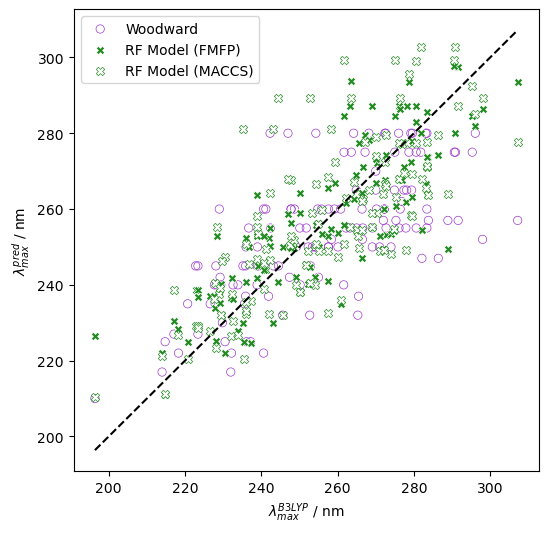

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))

sns.scatterplot(
    data=df_test,
    x='nm_b3lyp',
    y='nm_wf',
    marker='o',
    facecolors='none',
    edgecolor='darkorchid',
    label='Woodward'
)

sns.scatterplot(
    data=df_test,
    x='nm_b3lyp',
    y='nm_rf_fmfp',
    marker='X',
    color='forestgreen',
    label='RF Model (FMFP)'
)

sns.scatterplot(
    data=df_test,
    x='nm_b3lyp',
    y='nm_rf_maccs',
    marker='X',
    edgecolor='forestgreen',
    facecolor='white',
    label='RF Model (MACCS)'
)

# Add identity line for reference
plt.plot([df_test['nm_b3lyp'].min(), df_test['nm_b3lyp'].max()],
         [df_test['nm_b3lyp'].min(), df_test['nm_b3lyp'].max()],
         'k--', label='y = x')

plt.xlabel('$\lambda_{max}^{B3LYP}$ / nm')
plt.ylabel('$\lambda_{max}^{pred}$ / nm')

plt.show()

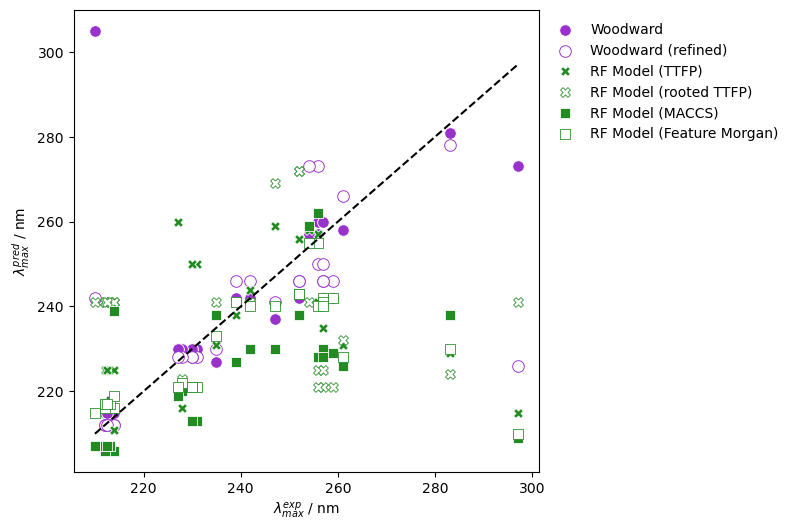

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))

sns.scatterplot(
    data=df_inference,
    x='nm_exp',
    y='nm_wf',
    marker='o',
    color='darkorchid',
    #edgecolor='darkorchid',
    label='Woodward',
    s=70
)

sns.scatterplot(
    data=df_inference,
    x='nm_exp',
    y='nm_wfr',
    marker='o',
    facecolors='white',
    edgecolor='darkorchid',
    label='Woodward (refined)',
    s=70
)

sns.scatterplot(
    data=df_inference,
    x='nm_exp',
    y='nm_rf_ttfp',
    marker='X',
    color='forestgreen',
    label='RF Model (TTFP)',
    s=50
)

sns.scatterplot(
    data=df_inference,
    x='nm_exp',
    y='nm_rf_rfp',
    marker='X',
    edgecolor='forestgreen',
    facecolor='white',
    label='RF Model (rooted TTFP)',
    s=50
)

sns.scatterplot(
    data=df_inference,
    x='nm_exp',
    y='nm_rf_maccs',
    marker='s',
    color='forestgreen',
    label='RF Model (MACCS)',
    s=50
)

sns.scatterplot(
    data=df_inference,
    x='nm_exp',
    y='nm_rf_fmfp',
    marker='s',
    edgecolor='forestgreen',
    facecolor='white',
    label='RF Model (Feature Morgan)',
    s=50
)
plt.legend(title=None, frameon=False, loc='upper left', bbox_to_anchor=(1.0, 1.0))

# Add identity line for reference
plt.plot([df_inference['nm_exp'].min(), df_inference['nm_exp'].max()],
         [df_inference['nm_exp'].min(), df_inference['nm_exp'].max()],
         'k--', label='y = x')

plt.xlabel('$\lambda_{max}^{exp}$ / nm')
plt.ylabel('$\lambda_{max}^{pred}$ / nm')

plt.show()

In [17]:
df_inference.to_csv('data_wf_rf-fit_samples.csv')

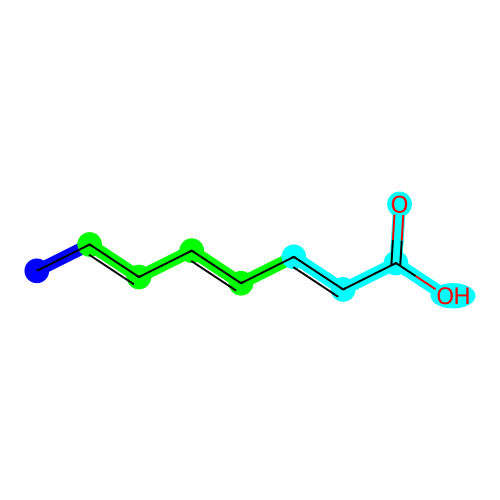

In [19]:
pred, descr, im = cp.predict('CC=CC=CC=CC(=O)O', solvent=None, verbose=True)
im

In [20]:
descr

{'base': 195,
 'factor': 60,
 'alpha': 'H',
 'alpha_all': [],
 'beta': 'H',
 'beta_all': [],
 'gamma': 'H',
 'gamma_all': [],
 'higher': 'alkyl',
 'higher_all': [{'pattern': 'alkyl', 'value': 18, 'sub_type': 'higher'}],
 'exo': 0,
 'solvent': 0}